# Generative Adversarial Networks Mini Project

In [1]:
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Data Set

In [3]:
import cs236781.plot as plot
import cs236781.download

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\Admin\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\Admin\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\Admin\.pytorch-datasets\lfw/George_W_Bush


In [4]:
# Data set object

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)


Found 530 images in dataset folder.


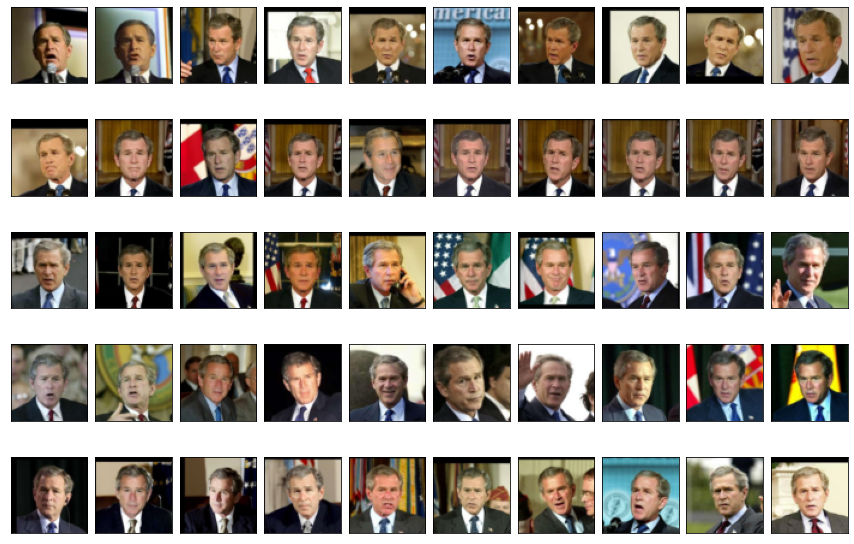

In [5]:
# Plot data set object

_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')


In [6]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

torch.Size([1, 3, 64, 64])


### Vanilla GAN 

In [ ]:
import project.gan as gan
from project.gan import discriminator_loss_fn
from project.gan import generator_loss_fn
# Vanilla Discriminator
dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)
# Generator
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)


torch.manual_seed(42)

#Discriminator loss function
y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10
D_loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(D_loss)

#Generator loss function
y_generated = torch.rand(20) * 10
G_loss = generator_loss_fn(y_generated, data_label=1)
print(G_loss)

#### Training

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

torch.manual_seed(42)
# GAN Hyperparameters
hypers = dict(batch_size=0,
        z_dim=0,
        data_label=0,
        label_noise=0.0,
        discriminator_optimizer=dict(
            type="",  # Any name in nn.optim like SGD, Adam
            lr=0.0,
            # You an add extra args for the optimizer here
        ),
        generator_optimizer=dict(
            type="",  # Any name in nn.optim like SGD, Adam
            lr=0.0,
            # You an add extra args for the optimizer here
        ),
    )
lr = 0.0002
hypers['batch_size'] = 4
hypers['z_dim'] = 512
hypers['data_label'] = 1
hypers['label_noise'] = 0.2
hypers['discriminator_optimizer']['type'] = 'Adam'
hypers['discriminator_optimizer']['lr'] = lr
hypers['generator_optimizer']['type'] = 'Adam'
hypers['generator_optimizer']['lr'] = lr * 5


batch_size = hypers['batch_size']
z_dim = hypers['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hypers['data_label'], hypers['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hypers['data_label'])

# Training
checkpoint_file = 'checkpoints/vanilla_gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hypers)

In [ ]:
import IPython.display
import tqdm
from project.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
vgan_samples = gen.sample(n=32, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

#### Inception Score

In [ ]:
from project.inception_score import IgnoreLabelDataset, inception_score

print (inception_score(IgnoreLabelDataset(vgan_samples), cuda=True, batch_size=32, resize=True, splits=10))


### SN-GAN 

In [ ]:
# Spectral Normalized Discriminator
sn_dsc = gan.Spectral_norm_Discriminator(in_size=x0[0].shape).to(device)
print(sn_dsc)

# Model
sn_dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
sn_dsc_optimizer = create_optimizer(sn_dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Training
checkpoint_file = 'checkpoints/sn_gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

#### Training

In [ ]:
import IPython.display
import tqdm
from project.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    sn_dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
sn_gan_samples = gen.sample(n=32, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

#### Inception Score

In [ ]:
from project.inception_score import IgnoreLabelDataset, inception_score

print (inception_score(IgnoreLabelDataset(sn_gan_samples), cuda=True, batch_size=32, resize=True, splits=10))


### WGAN 

In [ ]:
from torch.autograd import Variable

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizers
gen_optimizer = torch.optim.RMSprop(gen.parameters(), lr=lr)
dsc_optimizer = torch.optim.RMSprop(dsc.parameters(), lr=lr)

# Training
checkpoint_file = 'checkpoints/wgan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [ ]:
import IPython.display
import tqdm
from project.gan import Wasserstein_train_batch, save_checkpoint

num_epochs = 100

n_critic=5

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final
    
try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = Wasserstein_train_batch(
                    dsc, gen,
                    dsc_optimizer, gen_optimizer,
                    x_data,n_critic)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')


In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
wgan_samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

#### Inception Score

In [ ]:
from project.inception_score import IgnoreLabelDataset, inception_score

print (inception_score(IgnoreLabelDataset(wgan_samples), cuda=True, batch_size=32, resize=True, splits=10))
